# Loan defaults prediction using Sparkling Water

## Sparkling water Pipeline outline:

- Architecture
    - environment set-up:
        - `Pipenv`
        - `Spark`
        - `Jupyter`
        - `H2O`
    - how to run this notebook
- Set-up datasets using local spark warehouse
- `Spark:` Initial data exploration
    - target variable distribution
    - first hypotheses
    - data pre-processing
    - heavy feature engineering (leveraging Spark)
        - averages using window functions
        - removing non-significant keywords
    - data cleaning (simple operations that can be done in Spark)
- `H2O:`
    - variable encoding
    - outlier detection
    - leveraging `scikit-learn` for small scale pre-processing
    - set-up baseline model
    - develop more complex models (tracking performance with baseline to find the value of development)

![alt text](https://i0.wp.com/blog.h2o.ai/wp-content/uploads/2017/04/hdi-image5.jpg?resize=700%2C394)

## How to run this notebook on Amazon EC2 cluster:

 - clone the repo
 - run installation script
 - start jupyter notebook server
 - load the notebook
 - export Python envir for Spark
 - export AWS credentials for S3 bucket

Note: also using `scikit-learn` utilities are much easier with H2O Data Frame than with pySpark (due to the unordered character of Spark DataFrame)

As a master node I'm using AWS `t2.x2large` instance with following specs:

In [1]:
!sudo lshw -short

H/W path    Device  Class      Description
                    system     HVM domU
/0                  bus        Motherboard
/0/0                memory     96KiB BIOS
/0/401              processor  Intel(R) Xeon(R) CPU E5-2676 v3 @ 2.40GHz
/0/402              processor  CPU
/0/403              processor  CPU
/0/404              processor  CPU
/0/405              processor  CPU
/0/406              processor  CPU
/0/407              processor  CPU
/0/408              processor  CPU
/0/1000             memory     32GiB System Memory
/0/1000/0           memory     16GiB DIMM RAM
/0/1000/1           memory     16GiB DIMM RAM
/0/100              bridge     440FX - 82441FX PMC [Natoma]
/0/100/1            bridge     82371SB PIIX3 ISA [Natoma/Triton II]
/0/100/1.1          storage    82371SB PIIX3 IDE [Natoma/Triton II]
/0/100/1.3          bridge     82371AB/EB/MB PIIX4 ACPI
/0/100/2            display    GD 5446
/0/100/3            generic    Xen Platform Device
/1          eth0    network  

## Task description:

Lending Club is a Peer-to-Peer lending company that utilizes a group of private investors to fund loan requests. 

Lending Club’s model for risk assessment categorizes borrowers by assigning them a grade and a subgrade based on their credit history.

Investors are presented with a list of borrowers, along with their assigned risk assessment grades, and they have the opportunity to choose which borrowers they will fund, and the percentage of funding that they will cover.

Our business problem is that investors require a more comprehensive assessment of these borrowers than what is presented by Lending Club in order to make a smart business decision, by identifying new borrowers that would likely default on their loans.

-----

## User specified parameters

- `usr_s3_data_path` - path to s3 bucket with loan data
- `usr_min_error` - maximum acceptable FPR

In [2]:
usr_s3_data_path = 's3n://jakubs-bucket/club_loan/loan.csv'
usr_min_error = .05

## Setting data access

 - Loan csv file was loaded into the Amazon Simple Storage Service (S3) serving as a primary source of data and back-up
 - to speed up process of loading data into Spark DataFrame we loaded the data into local metastore

In [3]:
!tree /home/ubuntu/spark-warehouse/

/home/ubuntu/spark-warehouse/
└── loan.db
    └── data
        ├── part-00000-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        ├── part-00001-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        ├── part-00002-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        ├── part-00003-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        ├── part-00004-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        ├── part-00005-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        ├── part-00006-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        ├── part-00007-7d6d0974-d6d2-448a-b2fc-5f9c5ed96e66-c000.snappy.parquet
        └── _SUCCESS

2 directories, 9 files


### H2O Server

In [4]:
import h2o
from pysparkling import H2OContext
hc = H2OContext.getOrCreate(spark)

Connecting to H2O server at http://172.31.46.219:54321... successful.


H2O cluster uptime:,24 secs
H2O cluster version:,3.16.0.2
H2O cluster version age:,1 month and 21 days
H2O cluster name:,sparkling-water-ubuntu_local-1516483687011
H2O cluster total nodes:,1
H2O cluster free memory:,13.85 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://172.31.46.219:54321
H2O connection proxy:,None



Sparkling Water Context:
 * H2O name: sparkling-water-ubuntu_local-1516483687011
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (driver,172.31.46.219,54321)
  ------------------------

  Open H2O Flow in browser: http://172.31.46.219:54321 (CMD + click in Mac OSX)

    


## Data cleaning and feature engineering

In [5]:
from pyspark.sql.functions import udf, sum, col, when
from pyspark.sql.types import StringType
from loan_utils import *

sdf_loan = spark \
    .sql('select * from loan.data') \
    .persist()
    
sdf_loan.count()

887379

### Target variable (Loan status) preparation

In [6]:
tmp = sdf_loan.select('loan_status').groupBy('loan_status').count().orderBy('count').toPandas()
tmp = tmp.set_index('loan_status')
tmp.plot.barh()

In [7]:
loan_status_dict = {}
loan_status_dict['Does not meet the credit policy. Status:Charged Off'] = 'Default'
loan_status_dict['Default'] = 'Default'
loan_status_dict['Does not meet the credit policy. Status:Fully Paid'] = 'Fully Paid'
loan_status_dict['Late (16-30 days)'] = 'Current'
loan_status_dict['In Grace Period'] = 'Current'
loan_status_dict['Late (31-120 days)'] = 'Default'
loan_status_dict['Charged Off'] = 'Default'
loan_status_dict['Fully Paid'] = 'Fully Paid'
loan_status_dict['Current'] = 'Current'
loan_status_dict['Issued'] = None
loan_status_dict['Oct-2015'] = None

sdf_loan_clean = sdf_loan \
        .withColumn('loan_status', udf_recode_string(loan_status_dict)(col('loan_status'))) \
        .withColumn('loan_default', (col('loan_status') == 'Default').cast('int')) \

# remove observations with unclear data
sdf_loan_clean = filter_and_cast('loan_status', 'string', sdf_loan_clean)
sdf_loan_clean = filter_and_cast('loan_default', 'int', sdf_loan_clean)

Filtering and casting loan_status: removed 8461 (0.953%) cases due to the missing info 
Filtering and casting loan_default: removed 0 (0.000%) cases due to the missing info 


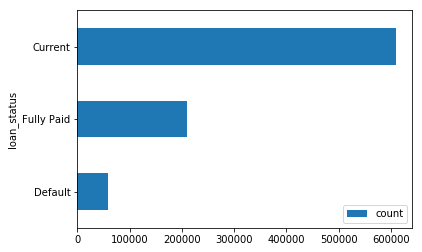

In [8]:
tmp = sdf_loan_clean.select('loan_status').groupBy('loan_status').count().orderBy('count').toPandas()
tmp = tmp.set_index('loan_status')
tmp.plot.barh()

### Loan variables preparation

In [9]:
from pyspark.sql.functions import unix_timestamp, from_unixtime, max, lit, datediff, add_months
from pyspark.sql import Window

w_all = Window.rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

In [10]:
sdf_loan_clean.groupBy('grade', 'sub_grade').count().orderBy(col('count').desc()).toPandas().head()

,grade,sub_grade,count
0,B,B3,55777
1,B,B4,55094
2,C,C1,52799
3,C,C2,51724
4,C,C3,49680


In [11]:
# variables describing loan itself
from pyspark.sql.functions import unix_timestamp, year, month, from_unixtime

var_descr_loan = ['issue_d', 
            'issue_d_year',
            'issue_d_month',
            'loan_amnt',
            'total_amnt_due',
            'int_rate',
            'installment',
            'term', 
            'term_n',
            'total_pymnt',
            'total_rec_prncp',
            'total_rec_prncp_perc',
            'out_prncp',
            'time_covered_prc'
                 ]

# filter null values and cast to appropriate types
sdf_loan_clean = filter_and_cast('total_pymnt', 'double', sdf_loan_clean)
sdf_loan_clean = filter_and_cast('total_rec_prncp', 'double', sdf_loan_clean)
sdf_loan_clean = filter_and_cast('out_prncp', 'double', sdf_loan_clean)

# create Spark dateteime object from issue_d
sdf_loan_clean = sdf_loan_clean \
        .withColumn('issue_d_ts', from_unixtime(unix_timestamp(col('issue_d'), format='MMM-yyyy'))) \
        .withColumn('issue_d_year', year(col('issue_d_ts'))) \
        .withColumn('issue_d_month', month(col('issue_d_ts')))
        
# create number of installments
sdf_loan_clean = sdf_loan_clean \
        .withColumn('term_n', when(col('term') == ' 36 months', lit(36.0)).otherwise(60))

# create total ammount due
sdf_loan_clean = sdf_loan_clean \
        .withColumn('total_amnt_due', col('term_n') * col('installment'))

# create percentage of the timeline covered by the data
max_issue_d = sdf_loan_clean.select('issue_d_ts').agg(max(col('issue_d_ts')).alias('m')).collect()
max_issue_d = max_issue_d[0]['m']

sdf_loan_clean = sdf_loan_clean \
    .withColumn('issue_d_ts_max', lit(max_issue_d)) \
    .withColumn('time_covered', datediff(col('issue_d_ts_max'), col('issue_d_ts'))) \
    .withColumn('time_to_payoff', col('term_n') * 30) \
    .withColumn('time_covered_prc', when(col('time_covered') / col('time_to_payoff') < 1.0,
                                        col('time_covered') / col('time_to_payoff')).otherwise(1.0)) \

# create percentage of debt paid
sdf_loan_clean = sdf_loan_clean \
        .withColumn('total_rec_prncp_perc', col('total_rec_prncp') / col('loan_amnt'))
    
    
# grade and subgrade
sdf_loan_clean = filter_and_cast('grade', 'string', sdf_loan_clean)
sdf_loan_clean = filter_and_cast('sub_grade', 'string', sdf_loan_clean)

Filtering and casting total_pymnt: removed 68 (0.008%) cases due to the missing info 
Filtering and casting total_rec_prncp: removed 24 (0.003%) cases due to the missing info 
Filtering and casting out_prncp: removed 76 (0.009%) cases due to the missing info 
Filtering and casting grade: removed 0 (0.000%) cases due to the missing info 
Filtering and casting sub_grade: removed 0 (0.000%) cases due to the missing info 


In [12]:
tmp = sdf_loan_clean.select(*var_descr_loan)

# check types and amount of missings
tmp.printSchema()
count_null_values(tmp)

root
 |-- issue_d: string (nullable = true)
 |-- issue_d_year: integer (nullable = true)
 |-- issue_d_month: integer (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- total_amnt_due: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- term: string (nullable = true)
 |-- term_n: double (nullable = false)
 |-- total_pymnt: double (nullable = true)
 |-- total_rec_prncp: double (nullable = true)
 |-- total_rec_prncp_perc: double (nullable = true)
 |-- out_prncp: double (nullable = true)
 |-- time_covered_prc: double (nullable = true)



,issue_d,issue_d_year,issue_d_month,loan_amnt,total_amnt_due,int_rate,installment,term,term_n,total_pymnt,total_rec_prncp,total_rec_prncp_perc,out_prncp,time_covered_prc
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
sdf_loan_clean.persist()
sdf_loan_clean.count()

878750

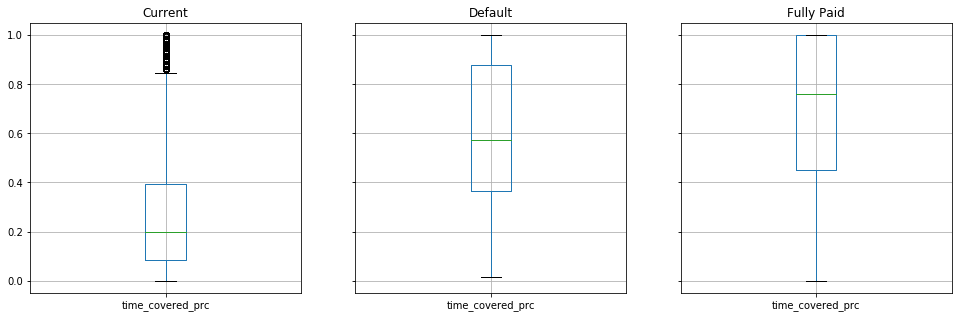

In [14]:
tmp = sdf_loan_clean \
    .select('loan_status', 'time_covered_prc') \
    .toPandas()

p = tmp.groupby('loan_status').boxplot(figsize=(16, 5), layout=(1, 3))    

### Loan description variables
 - title
 - user comments

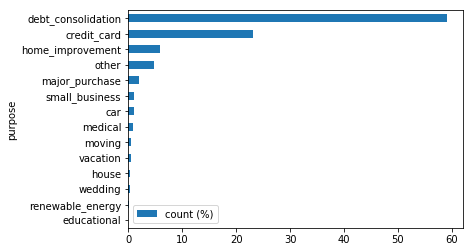

In [15]:
# frequency analysis of 'purpose'
import numpy as np

tmp = sdf_loan_clean.groupBy('purpose').count().orderBy(col('count').desc()).toPandas()
tmp['count (%)'] = tmp['count'] / tmp['count'].sum() * 100
tmp['count (cum %)'] = np.cumsum(tmp['count (%)'])
tmp = tmp.loc[tmp['count'] > 1, ].set_index('purpose')
tmp[['count (%)']].sort_values('count (%)', ascending=True).plot.barh()

In [16]:
# keep only texts with count > 1
loan_purpose_dict = {}
for lev in tmp.index.values:
    loan_purpose_dict[lev] = lev

sdf_loan_clean = sdf_loan_clean \
        .withColumn('purpose', udf_recode_string(loan_purpose_dict)(col('purpose')))
sdf_loan_clean = filter_and_cast('purpose', 'string', sdf_loan_clean)

Filtering and casting purpose: removed 86 (0.010%) cases due to the missing info 


### Generate key-words and 2-grams for title field

https://en.wikipedia.org/wiki/N-gram

In [17]:
# frequency analysis of 'title' (too many levels for categorical variable)

tmp = sdf_loan_clean.groupBy('title').count().orderBy(col('count').desc()).toPandas()
tmp['count (%)'] = tmp['count'] / tmp['count'].sum() * 100
tmp['count (cum %)'] = np.cumsum(tmp['count (%)'])

print(len(tmp.loc[tmp['count (cum %)'] < 95, 'count']))
tmp.head()

19025


,title,count,count (%),count (cum %)
0,Debt consolidation,409265,46.578100,46.578100
1,Credit card refinancing,162289,18.469973,65.048073
2,Home improvement,39631,4.510370,69.558443
3,Other,31422,3.576111,73.134554
4,Debt Consolidation,15757,1.793291,74.927845


In [18]:
sdf_loan_clean = sdf_loan_clean.drop('title_tokens',
                                     'title_words',
                                     'title_ngrams',
                                     'title_words_vec',
                                     'title_ngrams_vec',
                                     'title_words_vec_sig', 
                                     'title_ngrams_vec_sig').persist()

sdf_loan_clean.count()

878664

In [19]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, NGram, CountVectorizer, VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors


# remove records with null title value
sdf_loan_clean = filter_and_cast('title', 'string', sdf_loan_clean)

# split tile into words
tmp_tokenizer = Tokenizer(inputCol="title", outputCol="title_tokens")
sdf_loan_clean = tmp_tokenizer.transform(sdf_loan_clean)

# remove English stop words
tmp_remover = StopWordsRemover(inputCol="title_tokens",
                               outputCol="title_words",
                               stopWords=StopWordsRemover.loadDefaultStopWords('english'))
sdf_loan_clean = tmp_remover.transform(sdf_loan_clean)

# create n-grams
tmp_ngram = NGram(n=2, inputCol="title_words", outputCol="title_ngrams")
sdf_loan_clean = tmp_ngram.transform(sdf_loan_clean)



Filtering and casting title: removed 34 (0.004%) cases due to the missing info 


In [20]:
# create binary representation
cv = CountVectorizer(inputCol="title_words", 
                     outputCol="title_words_vec", 
                     binary=True,
                     minDF=100)

cv_fit = cv.fit(sdf_loan_clean)

sdf_loan_clean = cv_fit.transform(sdf_loan_clean).persist()
sdf_loan_clean.count()

878630

In [21]:
print(len(cv_fit.vocabulary))
cv_fit.vocabulary[0:10]

263


['consolidation',
 'debt',
 'credit',
 'card',
 'refinancing',
 'home',
 'improvement',
 'loan',
 'purchase',
 'major']

In [22]:
sdf_loan_clean.select('loan_default', 'title_words', 'title_words_vec').show(truncate=False)

+------------+-------------------------------------------+-------------------------------------+
|loan_default|title_words                                |title_words_vec                      |
+------------+-------------------------------------------+-------------------------------------+
|0           |[computer]                                 |(263,[],[])                          |
|1           |[bike]                                     |(263,[246],[1.0])                    |
|0           |[real, estate, business]                   |(263,[10],[1.0])                     |
|0           |[personel]                                 |(263,[],[])                          |
|0           |[personal]                                 |(263,[16],[1.0])                     |
|0           |[wedding, loan, promise, pay, back]        |(263,[7,12,28,54],[1.0,1.0,1.0,1.0]) |
|0           |[loan]                                     |(263,[7],[1.0])                      |
|0           |[car, downpaymen

In [23]:
title_word_sel = ChiSqSelector(fpr=.01, 
                               featuresCol="title_words_vec",
                               outputCol="title_words_vec_sig", 
                               labelCol="loan_default", 
                               selectorType='fpr')

sdf_loan_clean = title_word_sel.fit(sdf_loan_clean).transform(sdf_loan_clean)

In [24]:
sdf_loan_clean.select('loan_default', 'title_words', 'title_words_vec_sig').show(truncate=False)

+------------+-------------------------------------------+-------------------------------------+
|loan_default|title_words                                |title_words_vec_sig                  |
+------------+-------------------------------------------+-------------------------------------+
|0           |[computer]                                 |(190,[],[])                          |
|1           |[bike]                                     |(190,[],[])                          |
|0           |[real, estate, business]                   |(190,[10],[1.0])                     |
|0           |[personel]                                 |(190,[],[])                          |
|0           |[personal]                                 |(190,[15],[1.0])                     |
|0           |[wedding, loan, promise, pay, back]        |(190,[7,12,25,50],[1.0,1.0,1.0,1.0]) |
|0           |[loan]                                     |(190,[7],[1.0])                      |
|0           |[car, downpaymen

In [25]:
# create binary representation
cv_ng = CountVectorizer(inputCol="title_ngrams", 
                     outputCol="title_ngrams_vec", 
                     binary=True,
                     minDF=10)

cv_ng_fit = cv_ng.fit(sdf_loan_clean)

sdf_loan_clean = cv_ng_fit.transform(sdf_loan_clean).persist()
sdf_loan_clean.count()

878630

In [26]:
print(len(cv_ng_fit.vocabulary))
cv_ng_fit.vocabulary[0:10]

1456


['debt consolidation',
 'credit card',
 'card refinancing',
 'home improvement',
 'major purchase',
 'consolidation loan',
 'medical expenses',
 'car financing',
 'credit cards',
 'card consolidation']

In [27]:
sdf_loan_clean.select('loan_default', 'title_ngrams', 'title_ngrams_vec').show(truncate=False)

+------------+--------------------------------------------------------------+-------------------------+
|loan_default|title_ngrams                                                  |title_ngrams_vec         |
+------------+--------------------------------------------------------------+-------------------------+
|0           |[]                                                            |(1456,[],[])             |
|1           |[]                                                            |(1456,[],[])             |
|0           |[real estate, estate business]                                |(1456,[277],[1.0])       |
|0           |[]                                                            |(1456,[],[])             |
|0           |[]                                                            |(1456,[],[])             |
|0           |[wedding loan, loan promise, promise pay, pay back]           |(1456,[35,234],[1.0,1.0])|
|0           |[]                                                

In [28]:
title_ngrams_sel = ChiSqSelector(fpr=.01, 
                               featuresCol="title_ngrams_vec",
                               outputCol="title_ngrams_vec_sig", 
                               labelCol="loan_default", 
                               selectorType='fpr')

sdf_loan_clean = title_ngrams_sel.fit(sdf_loan_clean).transform(sdf_loan_clean)

In [29]:
sdf_loan_clean.select('title_ngrams', 'title_ngrams_vec_sig').show(truncate=False)

+--------------------------------------------------------------+---------------------+
|title_ngrams                                                  |title_ngrams_vec_sig |
+--------------------------------------------------------------+---------------------+
|[]                                                            |(366,[],[])          |
|[]                                                            |(366,[],[])          |
|[real estate, estate business]                                |(366,[],[])          |
|[]                                                            |(366,[],[])          |
|[]                                                            |(366,[],[])          |
|[wedding loan, loan promise, promise pay, pay back]           |(366,[29],[1.0])     |
|[]                                                            |(366,[],[])          |
|[car downpayment]                                             |(366,[],[])          |
|[expand business, business &, & buy, buy d

### Job information

In [30]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, NGram, CountVectorizer, VectorAssembler

# recode missing to 'None'
sdf_loan_clean = sdf_loan_clean \
    .withColumn('emp_title', when(col('emp_title').isNull(), 'None').otherwise(col('emp_title')))

In [31]:
# split tile into words
tmp_tokenizer = Tokenizer(inputCol="emp_title", outputCol="emp_title_tokens")
sdf_loan_clean = tmp_tokenizer.transform(sdf_loan_clean)

# remove English stop words
tmp_remover = StopWordsRemover(inputCol="emp_title_tokens",
                               outputCol="emp_title_words",
                               stopWords=StopWordsRemover.loadDefaultStopWords('english'))
sdf_loan_clean = tmp_remover.transform(sdf_loan_clean)

In [32]:
# create binary representation
cv_emp = CountVectorizer(inputCol="emp_title_words", 
                     outputCol="emp_title_words_vec", 
                     binary=True,
                     minDF=.01)

cv_emp_fit = cv_emp.fit(sdf_loan_clean)

sdf_loan_clean = cv_emp_fit.transform(sdf_loan_clean).persist()
sdf_loan_clean.count()

878630

In [33]:
tmp = sdf_loan_clean.groupBy('emp_title').count().orderBy(col('count').desc()).toPandas()
tmp['cum_freq'] = np.cumsum(tmp['count']) / tmp['count'].sum()
tmp_levs = tmp.loc[tmp['cum_freq'] <= .95, 'emp_title'].values

print('Detected {} levels for job title'.format(len(tmp_levs)))

Detected 253494 levels for job title


In [34]:
cv_emp_fit.vocabulary[0:10]

['manager',
 'none',
 'director',
 'sales',
 'assistant',
 'supervisor',
 'teacher',
 'engineer',
 'senior',
 'specialist']

In [35]:
sdf_loan_clean.select('emp_title_words_vec').show(truncate=False)

+-------------------+
|emp_title_words_vec|
+-------------------+
|(26,[1],[1.0])     |
|(26,[],[])         |
|(26,[1],[1.0])     |
|(26,[],[])         |
|(26,[],[])         |
|(26,[],[])         |
|(26,[],[])         |
|(26,[],[])         |
|(26,[1],[1.0])     |
|(26,[],[])         |
|(26,[],[])         |
|(26,[],[])         |
|(26,[],[])         |
|(26,[],[])         |
|(26,[],[])         |
|(26,[11],[1.0])    |
|(26,[],[])         |
|(26,[],[])         |
|(26,[],[])         |
|(26,[11],[1.0])    |
+-------------------+
only showing top 20 rows



In [36]:
# employment length
sdf_loan_clean.groupBy('emp_length').count().orderBy(col('count').desc()).show(20)
sdf_loan_clean = sdf_loan_clean \
    .withColumn('emp_length', when(col('emp_length').isNull(), 'Unknown').otherwise(col('emp_length')))
    
sdf_loan_clean = filter_and_cast('emp_length', 'string', sdf_loan_clean)

+----------+------+
|emp_length| count|
+----------+------+
| 10+ years|288708|
|   2 years| 78131|
|  < 1 year| 69786|
|   3 years| 69312|
|    1 year| 56513|
|   5 years| 55175|
|   4 years| 52007|
|   7 years| 44320|
|       n/a| 44187|
|   8 years| 43522|
|   6 years| 42616|
|   9 years| 34353|
+----------+------+

Filtering and casting emp_length: removed 0 (0.000%) cases due to the missing info 


In [37]:
# home ownership
sdf_loan_clean.groupBy('home_ownership').count().orderBy(col('count').desc()).show(20)
sdf_loan_clean = filter_and_cast('home_ownership', 'string', sdf_loan_clean)

+--------------+------+
|home_ownership| count|
+--------------+------+
|      MORTGAGE|439221|
|          RENT|352768|
|           OWN| 86407|
|         OTHER|   181|
|          NONE|    50|
|           ANY|     3|
+--------------+------+

Filtering and casting home_ownership: removed 0 (0.000%) cases due to the missing info 


In [38]:
# annual inc
sdf_loan_clean = filter_and_cast('annual_inc', 'double', sdf_loan_clean)

# loan share of the annual income 
sdf_loan_clean = sdf_loan_clean \
    .withColumn('loan_amnt_in_annual_inc', col('installment') * 12 / col('annual_inc'))

Filtering and casting annual_inc: removed 4 (0.000%) cases due to the missing info 


In [39]:
# verification status
sdf_loan_clean.groupBy('verification_status').count() \
    .orderBy('count').show()
    
vs_dict = {}
vs_dict['Not Verified'] = 'Not Verified'
vs_dict['Verified'] = 'Verified'
vs_dict['Source Verified'] = 'Verified'

sdf_loan_clean = sdf_loan_clean \
        .withColumn('verification_status', udf_recode_string(vs_dict)(col('verification_status'))) \

# remove observations with unclear data
sdf_loan_clean = filter_and_cast('verification_status', 'string', sdf_loan_clean)



+-------------------+------+
|verification_status| count|
+-------------------+------+
|       Not Verified|263794|
|           Verified|288149|
|    Source Verified|326683|
+-------------------+------+

Filtering and casting verification_status: removed 0 (0.000%) cases due to the missing info 


In [40]:
# zip code
sdf_loan_clean = filter_and_cast('zip_code', 'string', sdf_loan_clean)

tmp = sdf_loan_clean.groupBy('zip_code').count().orderBy(col('count').desc()).toPandas()
tmp['count (%)'] = tmp['count'] / tmp['count'].sum() * 100
tmp['count (cum %)'] = np.cumsum(tmp['count (%)'])

print(len(tmp.loc[tmp['count (cum %)'] < 95, 'count']))
tmp.head()

Filtering and casting zip_code: removed 0 (0.000%) cases due to the missing info 
581


,zip_code,count,count (%),count (cum %)
0,945xx,9680,1.101720,1.101720
1,750xx,9333,1.062227,2.163947
2,112xx,9163,1.042878,3.206825
3,606xx,8560,0.974248,4.181074
4,300xx,8036,0.914610,5.095683


In [41]:
### address state

sdf_loan_clean = filter_and_cast('addr_state', 'string', sdf_loan_clean)

tmp = sdf_loan_clean.groupBy('addr_state').count().orderBy(col('count').desc()).toPandas()
tmp['count (%)'] = tmp['count'] / tmp['count'].sum() * 100
tmp['count (cum %)'] = np.cumsum(tmp['count (%)'])

print(len(tmp.loc[tmp['count (cum %)'] < 95, 'count']))
tmp.head()

Filtering and casting addr_state: removed 0 (0.000%) cases due to the missing info 
32


,addr_state,count,count (%),count (cum %)
0,CA,128313,14.603825,14.603825
1,NY,73342,8.347351,22.951176
2,TX,70428,8.015697,30.966873
3,FL,60311,6.864240,37.831114
4,IL,35157,4.001361,41.832475


### Credit info

Filtering and casting dti: removed 0 (0.000%) cases due to the missing info 
root
 |-- id: integer (nullable = true)
 |-- dti: double (nullable = true)

1.138140687846706e-05
Filtering and casting dti: removed 10 (0.001%) cases due to the missing info 


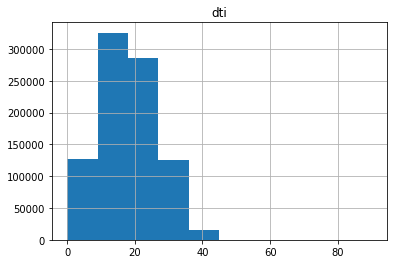

In [42]:
### dti
sdf_loan_clean = filter_and_cast('dti', 'double', sdf_loan_clean)
sdf_loan_clean.select('id','dti').printSchema()
sdf_loan_clean.select('id','dti').describe().toPandas()

tmp = sdf_loan_clean.select('dti').toPandas()
print((tmp['dti'] > 100).mean())

tmp[tmp['dti'] <= 100.0].hist()

sdf_loan_clean = sdf_loan_clean \
    .withColumn('dti', when(col('dti') > 100.0, None).otherwise(col('dti')))
    
sdf_loan_clean = filter_and_cast('dti', 'double', sdf_loan_clean)

Filtering and casting delinq_2yrs: removed 25 (0.003%) cases due to the missing info 
root
 |-- id: integer (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0caff3ff98>]],
      dtype=object)

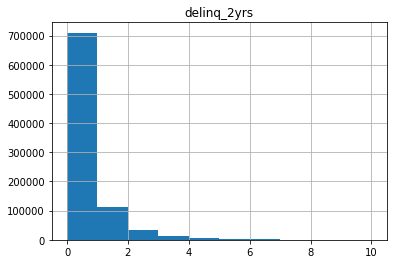

In [43]:
### delinq_2yrs
sdf_loan_clean = filter_and_cast('delinq_2yrs', 'integer', sdf_loan_clean)
sdf_loan_clean.select('id','delinq_2yrs').printSchema()
sdf_loan_clean.select('id','delinq_2yrs').describe().toPandas()

tmp = sdf_loan_clean.select('delinq_2yrs').toPandas()
tmp[tmp['delinq_2yrs'] <= 10.0].hist()

## Modeling

### Sample composition

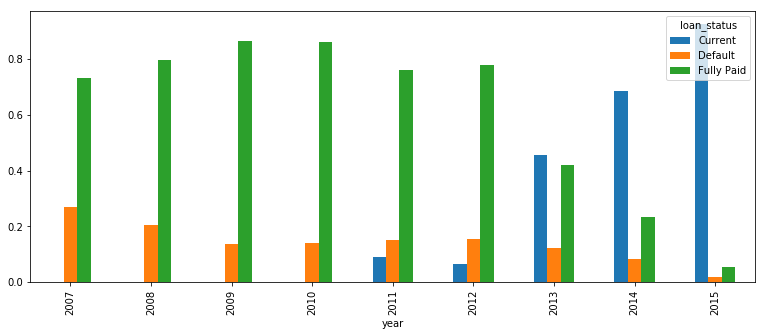

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tmp = sdf_loan_clean \
    .select('loan_status', col('issue_d_year').alias('year')) \
    .groupBy('loan_status', 'year').count() \
    .orderBy(col('count').asc()) \
    .toPandas()

def tmp_lambda(x):
    x[np.isnan(x)] = 0.0
    x = x / x.sum()
    return x
    
tmp \
    .pivot(index='year', columns='loan_status', values='count') \
    .apply(tmp_lambda, axis=1) \
    .plot.bar(figsize=(13, 5))

### Book ROI

In [45]:
tmp = sdf_loan_clean \
        .withColumn('loan_amnt', 
                    when(col('loan_status') == 'Current', col('total_rec_prncp')).otherwise(col('loan_amnt'))) \
        .select('loan_default', 'total_pymnt', 'loan_amnt', 'issue_d_year') \
        .groupBy('issue_d_year') \
        .agg(sum(col('loan_amnt')).alias('loan_amnt'), sum(col('total_pymnt')).alias('total_pymnt')) \
        .toPandas()

tmp['REVENUE'] = tmp['total_pymnt']  / 1e6       
tmp['PROFIT'] = (tmp['total_pymnt'] - tmp['loan_amnt']) / 1e6
tmp['ROI'] = tmp['total_pymnt'] / tmp['loan_amnt'] - 1.0

tmp.sort_values('issue_d_year', ascending=True)

,issue_d_year,loan_amnt,total_pymnt,REVENUE,PROFIT,ROI
0,2007,4.857100e+06,4.592342e+06,4.592342,-0.264758,-0.054510
8,2008,2.073080e+07,1.995242e+07,19.952424,-0.778376,-0.037547
5,2009,5.065520e+07,5.456492e+07,54.564924,3.909724,0.077183
6,2010,1.307162e+08,1.394485e+08,139.448501,8.732315,0.066804
7,2011,2.553960e+08,2.835202e+08,283.520239,28.124230,0.110120
4,2012,6.876583e+08,7.728441e+08,772.844089,85.185791,0.123878
2,2013,1.626120e+09,1.875183e+09,1875.182561,249.062767,0.153164
3,2014,1.917261e+09,2.227741e+09,2227.741103,310.480481,0.161940
1,2015,1.088725e+09,1.326208e+09,1326.207798,237.483261,0.218130


In [46]:
sdf_loan_clean.groupBy('term').count().show()

+----------+------+
|      term| count|
+----------+------+
| 36 months|614844|
| 60 months|263747|
+----------+------+



In [47]:
# Statistics for expired contracts
from pyspark.sql.functions import count

tmp = sdf_loan_clean \
        .filter(col('loan_status') != 'Current') \
        .select('loan_default', 'total_pymnt', 'loan_amnt', 'issue_d_year') \
        .groupBy('issue_d_year') \
        .agg(sum(col('loan_amnt')).alias('loan_amnt'), 
             sum(col('total_pymnt')).alias('total_pymnt'),
             sum(col('loan_default')).alias('n_defaults'),
             count(col('loan_default')).alias('n_loans'),
             sum(col('loan_default') * col('total_pymnt')).alias('total_pymnt_def'),
             sum(col('loan_default') * col('loan_amnt')).alias('loan_amnt_def')
            ) \
        .toPandas()

tmp['REVENUE'] = tmp['total_pymnt']  / 1e6       
tmp['PROFIT'] = (tmp['total_pymnt'] - tmp['loan_amnt']) / 1e6
tmp['ROI'] = tmp['total_pymnt'] / tmp['loan_amnt'] - 1.0
tmp['DRATE'] = tmp['n_defaults'] / tmp['n_loans']
tmp['LOSS'] = -(tmp['total_pymnt_def'] - tmp['loan_amnt_def']) / 1e6

tmp.sort_values('issue_d_year', ascending=True)

,issue_d_year,loan_amnt,total_pymnt,n_defaults,n_loans,total_pymnt_def,loan_amnt_def,REVENUE,PROFIT,ROI,DRATE,LOSS
0,2007,4.857100e+06,4.592342e+06,154,572,7.974882e+05,1538675.0,4.592342,-0.264758,-0.054510,0.269231,0.741187
8,2008,2.073080e+07,1.995242e+07,486,2352,2.343035e+06,4890725.0,19.952424,-0.778376,-0.037547,0.206633,2.547690
5,2009,5.065520e+07,5.456492e+07,702,5159,3.895991e+06,7401525.0,54.564924,3.909724,0.077183,0.136073,3.505534
6,2010,1.306300e+08,1.393281e+08,1745,12434,1.044114e+07,18419650.0,139.328097,8.698147,0.066586,0.140341,7.978511
7,2011,2.293101e+08,2.441772e+08,3259,19724,2.441386e+07,42674050.0,244.177160,14.867035,0.064834,0.165230,18.260190
4,2012,6.448179e+08,6.970534e+08,8334,49812,7.197315e+07,120365725.0,697.053381,52.235506,0.081008,0.167309,48.392571
2,2013,1.057072e+09,1.066971e+09,16798,73193,1.359862e+08,254241200.0,1066.971203,9.899703,0.009365,0.229503,118.254978
3,2014,1.061570e+09,9.552547e+08,19441,74154,1.041935e+08,293884575.0,955.254662,-106.315063,-0.100149,0.262171,189.691103
1,2015,4.520362e+08,3.633159e+08,7851,30835,1.854959e+07,120906075.0,363.315934,-88.720216,-0.196268,0.254613,102.356486


http://www.lendingmemo.com/lending-club-prosper-default-rates/

One of the main concerns people have in this investment is its average default rate, which means, the rate at which people fail to pay back these loans. This is a really valid issue considering the investor takes the full brunt of the loss when a borrower defaults. Risks like a platform bankruptcy or new regulatory burdens are important to keep in mind, but nothing has a more direct and negative impact upon our investment’s overall return than the rate at which our borrowers default on their loans.

### Balance classes

In [48]:
from pyspark.sql.functions import lit, when

sdf_loan_clean = sdf_loan_clean.withColumn('w', lit(1.0))

tmp_0 = sdf_loan_clean.filter(col('loan_default') == 0).agg(sum(col('w')).alias('w')).collect()[0].w
tmp_1 = sdf_loan_clean.filter(col('loan_default') == 1).agg(sum(col('w')).alias('w')).collect()[0].w
p_0 = tmp_0 / (tmp_0 + tmp_1) * 100
print('Class percentage before weighting: Y==1: {:2.2f}%, Y==0: {:2.2f}%'.format(100 - p_0, p_0))

# class weights
N = tmp_0 + tmp_1
w_0 = N * .5 / tmp_0
w_1 = N * .5 / tmp_1

# create weight column
sdf_loan_clean = sdf_loan_clean \
            .withColumn('w', when(col('loan_default') == 1, col('w') * w_1).otherwise(col('w') * w_0))
    
# sanity check
tmp_0 = sdf_loan_clean.filter(col('loan_default') == 0).agg(sum(col('w')).alias('w')).collect()[0].w
tmp_1 = sdf_loan_clean.filter(col('loan_default') == 1).agg(sum(col('w')).alias('w')).collect()[0].w
p_0 = tmp_0 / (tmp_0 + tmp_1) * 100
print('Class percentage after balancing: Y==1: {:2.2f}%, Y==0: {:2.2f}%'.format(100 - p_0, p_0))

Class percentage before weighting: Y==1: 6.69%, Y==0: 93.31%
Class percentage after balancing: Y==1: 50.00%, Y==0: 50.00%


### Transfer data from Spark to h2o

In [92]:
h2o.remove_all()

In [93]:
sdf_ft = ['loan_default', 
            'installment', 
            'issue_d_month',
            'loan_amnt', 
            'total_amnt_due',
            'int_rate',
            'grade',
            'sub_grade',
            'term_n',
            'purpose',
            'emp_length',
            'home_ownership',
            'annual_inc',
            'loan_amnt_in_annual_inc',
            'verification_status',
            'zip_code',
            'addr_state',
            'dti',
            'delinq_2yrs',
            'w']

df = hc.as_h2o_frame(sdf_loan_clean \
                     .select('issue_d_year',
                             'loan_status', 
                             'total_pymnt',
                             'title_words_vec_sig',
                             'title_ngrams_vec_sig',
                             'emp_title_words_vec',
                             *sdf_ft), framename='sdf_loan')

In [94]:
df['loan_default_fact'] = df['loan_default'].asfactor()
df['term_n_fact'] = df['term_n'].asfactor()
df['issue_d_month_fact'] = df['issue_d_month'].asfactor()
df['purpose_fact'] = df['purpose'].asfactor()
df['grade_fact'] = df['grade'].asfactor()
df['sub_grade_fact'] = df['sub_grade'].asfactor()

df['emp_length_fact'] = df['emp_length'].asfactor()
df['home_ownership_fact'] = df['home_ownership'].asfactor()
df['verification_status_fact'] = df['verification_status'].asfactor()
df['zip_code_fact'] = df['zip_code'].asfactor()
df['addr_state_fact'] = df['addr_state'].asfactor()
df['delinq_2yrs_fact'] = df['delinq_2yrs'].asfactor()

In [95]:
model_ft = ['loan_default_fact', 
            'installment', 
            'issue_d_month_fact',
            'loan_amnt', 
            'total_amnt_due',
            'int_rate',
            'grade_fact',
            'sub_grade_fact',
            'term_n_fact',
            'purpose_fact',
            'emp_length_fact',
            'home_ownership_fact',
            'annual_inc',
            'loan_amnt_in_annual_inc',
            'verification_status_fact',
            'zip_code_fact',
            'addr_state_fact',
            'delinq_2yrs_fact',
            'dti',
            'w']

In [96]:
nmes = df[1:10, :].as_data_frame()
nmes = list(nmes.columns)

In [97]:
ind = pd.DataFrame([(nme[0:19] == 'title_words_vec_sig', nme) for nme in nmes], columns=['match', 'nme'])
model_title_word_ft = list(ind[ind['match']]['nme'].values)

ind = pd.DataFrame([(nme[0:20] == 'title_ngrams_vec_sig', nme) for nme in nmes], columns=['match', 'nme'])
model_title_ngram_ft = list(ind[ind['match']]['nme'].values)

ind = pd.DataFrame([(nme[0:19] == 'emp_title_words_vec', nme) for nme in nmes], columns=['match', 'nme'])
model_emp_title_ft = list(ind[ind['match']]['nme'].values)

### Test, Train, Validate

Few comments about splitting the dataset (date and Keyword are the key)

In [143]:
predictors = model_ft[1:-1] + model_title_word_ft + model_title_ngram_ft + model_emp_title_ft
response = 'loan_default_fact'
weight = model_ft[-1]

train, validate, test = df.split_frame([.5, .2], seed=2014)

test['w'] = 1.0


# TODO: print samlple sizes
train.nrows

439500

### Baseline model: Lasso Logistic regression

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/GLMBooklet.pdf  
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html

#### Tune lasso parameters

In [127]:
from h2o.grid import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

import numpy as np

h2o.remove('glm_grid')
lambda_grid = list(np.logspace(start=-7.0, stop=0.0, num=10, base=10.0))
lambda_grid.append(0.0)

glm_grid = H2OGridSearch(
        model=H2OGeneralizedLinearEstimator(family="binomial", alpha=1.0),
        hyper_params={"lambda": lambda_grid},
        grid_id='glm_grid'
    )

glm_grid.train(predictors, response, training_frame=train, validation_frame=validate, weights_column=weight)

glm Grid Build progress: |████████████████████████████████████████████████| 100%


In [128]:
import pandas as pd

# get the AUC on validation set:
pd_auc = pd.DataFrame(list(glm_grid.auc(valid=True).items()), columns=['Model_ID', 'AUC']).sort_values('AUC', ascending=False)
model_ids = pd_auc['Model_ID'].values
pd_auc['lambda'] = np.array([glm_grid.get_hyperparams_dict(model, display=False)['lambda'] for model in model_ids])
pd_auc = pd_auc.sort_values('AUC', ascending=False)

# select best model hyperparameters
glm_best_model_lambda = pd_auc['lambda'].values[0]
glm_best_model_AUC = pd_auc['AUC'].values[0]

pd_auc

,Model_ID,AUC,lambda
5,glm_grid_model_3,0.736744,2.154435e-05
2,glm_grid_model_4,0.735899,1.291550e-04
9,glm_grid_model_2,0.735071,3.593814e-06
4,glm_grid_model_10,0.734578,0.000000e+00
3,glm_grid_model_1,0.734235,5.994843e-07
7,glm_grid_model_0,0.734109,1.000000e-07
8,glm_grid_model_5,0.726184,7.742637e-04
6,glm_grid_model_6,0.705173,4.641589e-03
1,glm_grid_model_7,0.692893,2.782559e-02
0,glm_grid_model_9,0.500000,1.000000e+00


#### Final model

In [152]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

glm_model = H2OGeneralizedLinearEstimator(family="binomial", 
                                          lambda_=glm_best_model_lambda, 
                                          standardize=True,
                                          alpha=1.0,
                                          max_iterations=100,
                                          nfolds = 0,
                                          seed = 2014,
                                          keep_cross_validation_predictions=True
                                         )

glm_model.train(predictors, response, training_frame=train, validation_frame=validate, weights_column=weight)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [153]:
thr_grid = [i / 1000 for i in range(786, 791)]
thr_grid_recall_train = pd.DataFrame(glm_model.recall(thr_grid, train=True), columns=['thr', 'RECALL'])
thr_grid_fpr_train = pd.DataFrame(glm_model.fpr(thr_grid, train=True), columns=['thr', 'FPR'])
thr_grid_recall_valid = pd.DataFrame(glm_model.recall(thr_grid, valid=True), columns=['thr', 'RECALL (valid)'])
thr_grid_fpr_valid = pd.DataFrame(glm_model.fpr(thr_grid, valid=True), columns=['thr', 'FPR (valid)'])

thr_grid = thr_grid_recall_train.merge(thr_grid_fpr_train).merge(thr_grid_recall_valid).merge(thr_grid_fpr_valid)
thr_grid['< min_error'] = thr_grid['FPR (valid)'] <= usr_min_error
glm_thr_grid = thr_grid
glm_sel_thr = thr_grid.loc[thr_grid['< min_error'], 'thr'].min()

glm_thr_grid

Could not find exact threshold 0.786; using closest threshold found 0.7871555635843727.
Could not find exact threshold 0.787; using closest threshold found 0.7871555635843727.
Could not find exact threshold 0.788; using closest threshold found 0.7871555635843727.
Could not find exact threshold 0.789; using closest threshold found 0.7894477195105223.
Could not find exact threshold 0.79; using closest threshold found 0.7894477195105223.
Could not find exact threshold 0.786; using closest threshold found 0.7871555635843727.
Could not find exact threshold 0.787; using closest threshold found 0.7871555635843727.
Could not find exact threshold 0.788; using closest threshold found 0.7871555635843727.
Could not find exact threshold 0.789; using closest threshold found 0.7894477195105223.
Could not find exact threshold 0.79; using closest threshold found 0.7894477195105223.
Could not find exact threshold 0.786; using closest threshold found 0.7858490566221445.
Could not find exact threshold 0.7

,thr,RECALL,FPR,RECALL (valid),FPR (valid),< min_error
0,0.786,0.191483,0.048986,0.185469,0.050392,False
1,0.787,0.191483,0.048986,0.185469,0.050392,False
2,0.788,0.191483,0.048986,0.181206,0.048842,True
3,0.789,0.186950,0.047732,0.181206,0.048842,True
4,0.790,0.186950,0.047732,0.181206,0.048842,True


In [154]:
glm_sel_thr

0.788

In [155]:
glm_model.model_performance(test) \
    .confusion_matrix(thresholds=[glm_sel_thr])

Could not find exact threshold 0.788; using closest threshold found 0.7879621018279034.
Confusion Matrix (Act/Pred) @ threshold = 0.7879621018279034: 


,0,1,Error,Rate
0,125325.0,6464.0,0.049,(6464.0/131789.0)
1,107121.0,23530.0,0.8199,(107121.0/130651.0)
Total,232446.0,29994.0,0.4328,(113585.0/262440.0)


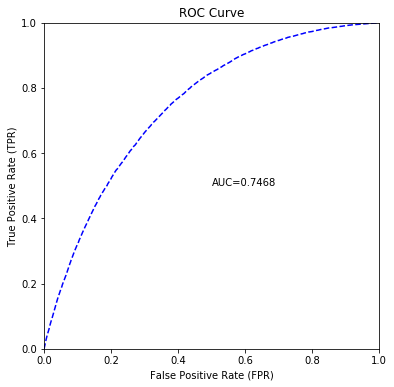

In [156]:
tmp = glm_model.model_performance(test)
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 6))
tmp.plot()

# TODO: in presentation add line at y = .95

### Business Metrics

In [157]:
from loan_utils import calc_roi

In [158]:
# get porfolio stats with specific threshold for default detection
res = test.cbind(glm_model.predict(test))
res = res[res['loan_status'] != 'Current']

glm prediction progress: |████████████████████████████████████████████████| 100%


In [159]:
calc_roi(res, 1.0)

Issue Year,REVENUE (in mln),PROFIT (in mln),ROI (%),DEFAULT RATE(%),LOSS (in mln)
2007,1.38,-0.11,-7.53,28.1768,0.268228
2008,5.72,-0.28,-4.66,23.6496,0.845662
2009,16.18,1.14,7.56,13.7179,1.04297
2010,41.33,2.54,6.55,13.7763,2.4652
2011,72.99,4.71,6.9,15.6909,5.23277
2012,209.3,15.99,8.27,16.4084,14.3864
2013,318.83,2.13,0.67,23.1023,36.0016
2014,288.77,-31.87,-9.94,26.1065,57.2629
2015,110.42,-25.85,-18.97,24.8925,30.0948


In [160]:
calc_roi(res, glm_sel_thr)

Issue Year,REVENUE (in mln),PROFIT (in mln),ROI (%),DEFAULT RATE(%),LOSS (in mln)
2007,1.36,-0.11,-7.76,28.6517,0.268228
2008,5.61,-0.26,-4.47,23.1343,0.81803
2009,15.06,1.12,8.05,13.278,0.909551
2010,39.81,2.54,6.82,13.3352,2.24044
2011,69.29,4.74,7.35,14.8788,4.61242
2012,171.39,13.84,8.79,14.3978,10.0236
2013,251.49,4.84,1.96,19.7603,23.9661
2014,278.87,-29.07,-9.44,25.1613,53.2717
2015,107.16,-23.54,-18.01,23.8906,27.5697


In [161]:
res['pp'] = res['p1'] > glm_sel_thr
tmp = res.group_by('grade_fact').sum('pp').count().get_frame()
tmp['(%)'] = tmp['sum_pp'] /  tmp['nrow'] * 100.0
tmp.as_data_frame()[['grade_fact', '(%)']]

,grade_fact,(%)
0,A,0.509325
1,B,3.215243
2,C,10.745583
3,D,22.070061
4,E,25.772098
5,F,38.655147
6,G,59.745763


In [162]:
tmp1 = calc_roi(res, glm_sel_thr)
tmp2 = calc_roi(res, 1.1)
tmp1['PROFIT (in mln)'].sum() - tmp2['PROFIT (in mln)'].sum()

5.699999999999999

### XGboost


#### Tune xgboost Parameters

In [144]:
from h2o.grid import H2OGridSearch
from h2o.estimators.xgboost import H2OXGBoostEstimator
import numpy as np

h2o.remove('xgb_grid')
booster_grid = ['gbtree']
depth_grid = [6, 7, 8, 9, 10]

xgb_grid = H2OGridSearch(
        model=H2OXGBoostEstimator(distribution='multinomial', 
                                       stopping_metric='auc', 
                                       stopping_rounds=3),
        hyper_params={'max_depth': depth_grid, 
                      'booster': booster_grid},
        grid_id='xgb_grid'
    )

xgb_grid.train(predictors, response, training_frame=train, validation_frame=validate, weights_column = weight)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [145]:
# get the AUC on validation set:
pd_auc = pd.DataFrame(list(xgb_grid.auc(valid=True).items()), columns=['Model_ID', 'AUC']).sort_values('AUC', ascending=False)
model_ids = pd_auc['Model_ID'].values

pd_auc['booster'] = np.array([xgb_grid.get_hyperparams_dict(model, display=False)['booster'] for model in model_ids])
pd_auc['max_depth'] = np.array([xgb_grid.get_hyperparams_dict(model, display=False)['max_depth'] for model in model_ids])

pd_auc = pd_auc.sort_values('AUC', ascending=False)

# select best model hyperparameters and remove the grid
xgb_best_model_depth = pd_auc['max_depth'].values[0]
xgb_best_model_booster = pd_auc['booster'].values[0]
xgb_best_model_AUC = pd_auc['AUC'].values[0]

pd_auc.head(10)

,Model_ID,AUC,booster,max_depth
0,xgb_grid_model_2,0.775011,gbtree,7
3,xgb_grid_model_3,0.775011,dart,7
1,xgb_grid_model_0,0.773318,gbtree,6
8,xgb_grid_model_1,0.773318,dart,6
6,xgb_grid_model_4,0.772246,gbtree,8
9,xgb_grid_model_5,0.772246,dart,8
2,xgb_grid_model_6,0.766827,gbtree,9
4,xgb_grid_model_7,0.766827,dart,9
5,xgb_grid_model_8,0.762315,gbtree,10
7,xgb_grid_model_9,0.762315,dart,10


#### Final model

In [146]:
from h2o.estimators.xgboost import H2OXGBoostEstimator

xgb_model = H2OXGBoostEstimator(distribution="multinomial", 
                                    booster=xgb_best_model_booster, 
                                    max_depth=int(xgb_best_model_depth),
                                    nfolds = 0,
                                    seed = 2014,
                                    stopping_metric='auc',
                                    stopping_rounds=3,
                                    ntrees=50,
                                    keep_cross_validation_predictions=True
                                    )

xgb_model.train(predictors, response, training_frame=train, validation_frame=validate, weights_column=weight)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


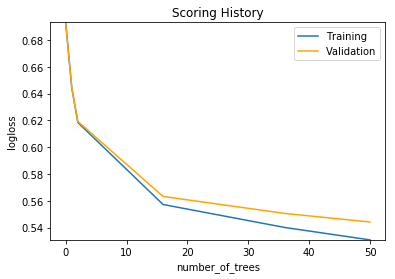

In [147]:
xgb_model.plot()

In [163]:
thr_grid = [i / 1000 for i in range(759, 764)]
thr_grid_recall_train = pd.DataFrame(xgb_model.recall(thr_grid, train=True), columns=['thr', 'RECALL'])
thr_grid_fpr_train = pd.DataFrame(xgb_model.fpr(thr_grid, train=True), columns=['thr', 'FPR'])
thr_grid_recall_valid = pd.DataFrame(xgb_model.recall(thr_grid, valid=True), columns=['thr', 'RECALL (valid)'])
thr_grid_fpr_valid = pd.DataFrame(xgb_model.fpr(thr_grid, valid=True), columns=['thr', 'FPR (valid)'])

thr_grid = thr_grid_recall_train.merge(thr_grid_fpr_train).merge(thr_grid_recall_valid).merge(thr_grid_fpr_valid)
thr_grid['> min_recall'] = thr_grid['FPR (valid)'] <= usr_min_error
xgb_thr_grid = thr_grid
xgb_sel_thr = thr_grid.loc[thr_grid['> min_recall'], 'thr'].min()

xgb_thr_grid

Could not find exact threshold 0.759; using closest threshold found 0.7588227778824971.
Could not find exact threshold 0.76; using closest threshold found 0.760425485447792.
Could not find exact threshold 0.761; using closest threshold found 0.760425485447792.
Could not find exact threshold 0.762; using closest threshold found 0.7619638445023991.
Could not find exact threshold 0.763; using closest threshold found 0.7635227466252312.
Could not find exact threshold 0.759; using closest threshold found 0.7588227778824971.
Could not find exact threshold 0.76; using closest threshold found 0.760425485447792.
Could not find exact threshold 0.761; using closest threshold found 0.760425485447792.
Could not find exact threshold 0.762; using closest threshold found 0.7619638445023991.
Could not find exact threshold 0.763; using closest threshold found 0.7635227466252312.
Could not find exact threshold 0.759; using closest threshold found 0.758696200472585.
Could not find exact threshold 0.76; us

,thr,RECALL,FPR,RECALL (valid),FPR (valid),> min_recall
0,0.759,0.272324,0.048229,0.216253,0.051746,False
1,0.760,0.267623,0.047132,0.211648,0.050447,False
2,0.761,0.267623,0.047132,0.211648,0.050447,False
3,0.762,0.263192,0.045983,0.207044,0.049025,True
4,0.763,0.258828,0.044866,0.207044,0.049025,True


In [164]:
xgb_sel_thr

0.762

In [165]:
xgb_model.model_performance(test).confusion_matrix(thresholds=[xgb_sel_thr])

Could not find exact threshold 0.762; using closest threshold found 0.7620359769134303.
Confusion Matrix (Act/Pred) @ threshold = 0.7620359769134303: 


,0,1,Error,Rate
0,125296.0,6493.0,0.0493,(6493.0/131789.0)
1,104146.0,26505.0,0.7971,(104146.0/130651.0)
Total,229442.0,32998.0,0.4216,(110639.0/262440.0)


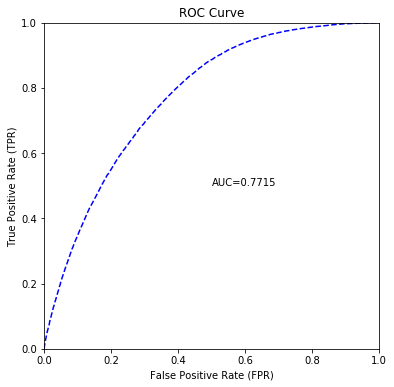

In [166]:
tmp = xgb_model.model_performance(test)
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 6))
tmp.plot()

# TODO: in presentation add line at y = .95

### Business Metrics

In [167]:
# get porfolio stats with specific threshold for default detection
res = test.cbind(xgb_model.predict(test))
res = res[res['loan_status'] != 'Current']

xgboost prediction progress: |████████████████████████████████████████████| 100%


In [168]:
calc_roi(res, 1.0)

Issue Year,REVENUE (in mln),PROFIT (in mln),ROI (%),DEFAULT RATE(%),LOSS (in mln)
2007,1.38,-0.11,-7.53,28.1768,0.268228
2008,5.72,-0.28,-4.66,23.6496,0.845662
2009,16.18,1.14,7.56,13.7179,1.04297
2010,41.33,2.54,6.55,13.7763,2.4652
2011,72.99,4.71,6.9,15.6909,5.23277
2012,209.3,15.99,8.27,16.4084,14.3864
2013,318.83,2.13,0.67,23.1023,36.0016
2014,288.77,-31.87,-9.94,26.1065,57.2629
2015,110.42,-25.85,-18.97,24.8925,30.0948


In [169]:
calc_roi(res, xgb_sel_thr)

Issue Year,REVENUE (in mln),PROFIT (in mln),ROI (%),DEFAULT RATE(%),LOSS (in mln)
2007,0.98,-0.11,-10.21,27.0073,0.214219
2008,4.19,-0.15,-3.56,21.6319,0.524611
2009,14.25,1.04,7.86,12.8223,0.840729
2010,35.51,2.08,6.21,12.1597,1.84723
2011,64.42,4.56,7.62,13.8721,3.87791
2012,165.16,13.76,9.09,13.6619,8.85364
2013,254.43,5.78,2.32,19.4089,23.2508
2014,274.26,-27.61,-9.15,24.8603,51.3301
2015,108.47,-24.3,-18.3,24.2654,28.4042


In [170]:
res['pp'] = res['p1'] > xgb_sel_thr
tmp = res.group_by('grade_fact').sum('pp').count().get_frame()
tmp['(%)'] = tmp['sum_pp'] /  tmp['nrow'] * 100.0
tmp.as_data_frame()

,grade_fact,nrow,sum_pp,(%)
0,A,12762,60,0.470146
1,B,23513,563,2.394420
2,C,20883,2145,10.271513
3,D,13217,3154,23.863206
4,E,6573,2197,33.424616
5,F,2662,1274,47.858753
6,G,708,478,67.514124


In [171]:
tmp1 = calc_roi(res, xgb_sel_thr)
tmp2 = calc_roi(res, 1.1)
tmp1['PROFIT (in mln)'].sum() - tmp2['PROFIT (in mln)'].sum()

6.649999999999995

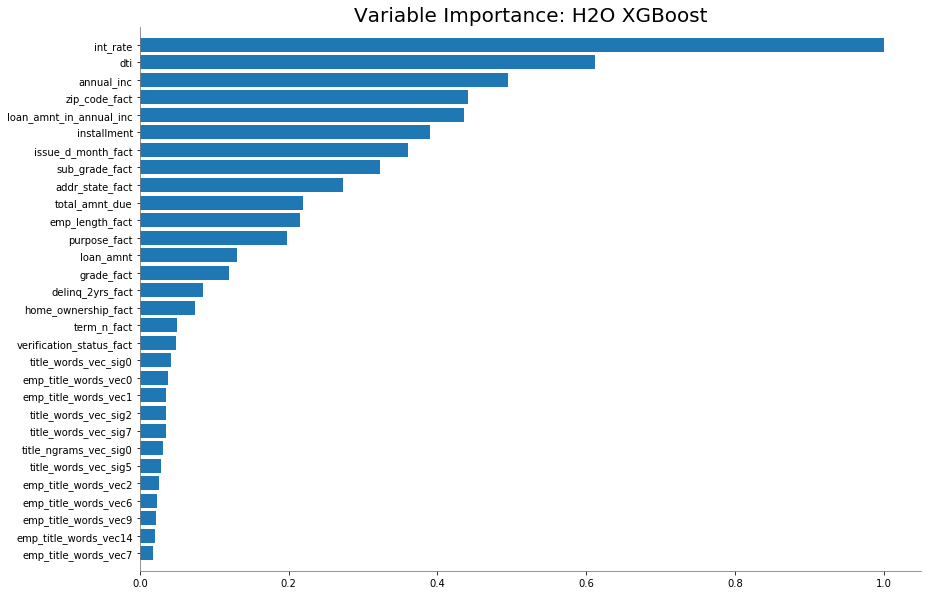

In [172]:
xgb_model.varimp_plot(num_of_features=30)